In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.linear_model import Perceptron
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
from sklearn.metrics import confusion_matrix


## data 

در این بخش دیتای مورد نیاز برای کارمان را با استفاده از کد زیر دریافت می‌کنیم
سپس دیتاها و تارگتشان را در دو متغیر ذخیره می‌کنیم

In [2]:
mnist = fetch_openml('mnist_784')
data= mnist['data']
target = mnist["target"]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## variables

در این بخش متغیرهای استفاده شده در برنامه را تعریف می‌کنیم که درصورت لزوم بتوانیم به راحتی اعداد و چیزهای مورد نیاز را تغییر دهیم و نتایج جدید را به‌دست آوریم 

In [3]:
random_state= 42
n_splits= 5
shuffle= True
iterations= 10
train_accuracy_data={2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
val_accuracy_data={2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}

## models

در این بخش مدل‌های مختلفی که در برنامه مورد نیاز است را یکبار تعریف می‌کنیم تا در ادامه تنها آن‌ها را صدا کنیم همچنین دیتایمان را نیز به بخش‌های مختلف تقسیم کرده‌ایم

In [4]:
kFold_handler=KFold(n_splits=n_splits, shuffle=shuffle) 
perceptron = Perceptron() 
scaler = StandardScaler()

x_train, x_test, y_train, y_test = train_test_split(data, 
                                                    target,
                                                    test_size=0.2,
                                                    random_state=random_state)
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## reusable functions

در این بخش من توابع تکرار شونده مانند فیت کننده‌ی ال دی ای را قرار داده‌ام تا در ادامه در دسترسم باشند و بتوانم به راحتی از آن‌ها استفاده کنم

In [5]:
def LDA_calculator(number, x_train_data, y_train_data):
    lda = LinearDiscriminantAnalysis(n_components=number)
    X_train_lda = lda.fit_transform(x_train_data, y_train_data)
    X_test_lda = lda.transform(x_test_scaled)
    return X_train_lda, X_test_lda

def PCA_calculator(n_components, x_train, x_test):
    pca = PCA(n_components= n_components)
    x_train_pca = pca.fit_transform(x_train)
    x_test_pca = pca.transform(x_test)
    return x_train_pca, x_test_pca

def model_predictor(X_train, y_train, X_test, y_test, model_type='perceptron', C=1.0):
    if model_type == 'logistic':
        model = Perceptron(penalty='l1', alpha=C)
    else:
        model = perceptron

    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    return train_accuracy, test_accuracy

def accuracy_calculator(type, model_type='perceptron', C=1, polynomial= False):
    iterations= 10
    all_components = enumerate([2, 3, 4, 5, 6, 7, 8, 9], start=1) if type == "LDA" else enumerate([2, 5, 10, 15, 20, 30], start=1)
    for j, n_components in all_components:
        if(type == 'LDA'):
            x_train_calculated, x_test_calculated= LDA_calculator(n_components, x_train_scaled, y_train)
        else:
            x_train_calculated, x_test_calculated= PCA_calculator(n_components, x_train_scaled, x_test_scaled)
        x_train_calculated_df = pd.DataFrame(x_train_calculated)
        if polynomial:
            poly = PolynomialFeatures(degree=2)
            x_train_polynomial = poly.fit_transform(x_train_calculated)
            x_test_polynomial = poly.transform(x_test_calculated)
            x_train_calculated_df = pd.DataFrame(x_train_polynomial)
        
        for i in range(iterations):
            train_accuracies = [] 
            test_accuracies = [] 
            for train_index, test_index in kFold_handler.split(x_train_calculated_df, y_train): 
                X_train_kFold, X_test_kFold = x_train_calculated_df.iloc[train_index], x_train_calculated_df.iloc[test_index] 
                y_train_kFold, y_test_kFold = y_train.iloc[train_index], y_train.iloc[test_index] 
                train_accuracy, test_accuracy = model_predictor(X_train_kFold, y_train_kFold, X_test_kFold, y_test_kFold, model_type=model_type, C=C)
                train_accuracies.append(train_accuracy) 
                test_accuracies.append(test_accuracy)
            train_accuracy_data[n_components].append(np.mean(train_accuracies))
            val_accuracy_data[n_components].append(np.mean(test_accuracies))
        print(f"for {n_components} train mean accuracy is: {np.mean(train_accuracy_data[n_components])} and test mean accuracy is: {np.mean(val_accuracy_data[n_components])}")

def draw_plots(type):
    plt.figure(figsize=[15, 10])
    all_components = enumerate([2, 3, 4, 5, 6, 7, 8, 9], start=1) if type == "LDA" else enumerate([2, 5, 10, 15, 20, 30], start=1)
    for i, n_components in all_components:
        plt.subplot(2, 4, i)
        plt.boxplot([train_accuracy_data[n_components], val_accuracy_data[n_components]])
        plt.title(f'accuracies from {type} with {n_components} components')
        plt.xlabel('Train(1) / Validation(2)')
        plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

## question2 part 1

در این بخش به بخش اول سوال دوم پرداخته‌ام و می‌خواهم ۵فولد را با ۱۰ بار تکرار برای ال دی ای با کامپوننت‌های مختلف اجرا کنم و مدل پرسپترونشان را فیت کنم سپس نتایج را ذخیره کنم تا بتوانیم باکس پلات‌های مورد نیاز را رسم کنیم و نتایج را بررسی کنیم 

In [6]:
train_accuracy_data={2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
val_accuracy_data={2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
accuracy_calculator('LDA')


for 2 train mean accuracy is: 0.3113888392857143 and test mean accuracy is: 0.31103214285714287
for 3 train mean accuracy is: 0.4909 and test mean accuracy is: 0.49086785714285713
for 4 train mean accuracy is: 0.6276308035714285 and test mean accuracy is: 0.6285339285714285
for 5 train mean accuracy is: 0.6670660714285714 and test mean accuracy is: 0.6673357142857144
for 6 train mean accuracy is: 0.71984375 and test mean accuracy is: 0.7190589285714285
for 7 train mean accuracy is: 0.7625540178571428 and test mean accuracy is: 0.762175
for 8 train mean accuracy is: 0.8202223214285713 and test mean accuracy is: 0.8206749999999999
for 9 train mean accuracy is: 0.8306147321428572 and test mean accuracy is: 0.8300589285714286


## box plots

در این بخش ما نتایج دقت‌ همه‌ی مدل‌ها را داریم و تنها لازم است باکس پلات‌ها را برای داده‌های ترین و تست رسم کنیم تا ببینیم نتایج ما به چه شکل شده است

### results (question2 part 2)

حال با توجه به نمودارها به راحتی می‌توانیم ببینیم در حالت‌هایی که ال دی ای با تعداد کامپوننت‌های کم‌تری داریم دقت بسیار پایین است چه روی ترین چه روی تست پس به وضوح میتوان گفت زیربرازش اتفاق افتاده است برای مثال در ۲ بخشی کردن دقت ما در حدود ۳۲٪ می‌باشد که عدد بسیار پایینی است

در ادامه مشاهده می‌شود که وقتی به تعداد ۸ یا ۹ بخش می‌رسیم دقت ما چه در تست چه در ترین به شدت افزایش یافته و دقت‌های بالای ۸۰٪ را به ثبت رسانده‌ایم و نکته خوب ماجرا این است که در تست نیز افزایش را داشته‌ایم پس می‌توان گفت بیش برازش نیز اتفاق نیفتاده‌است

حال در ادامه می‌خواهیم به سراغ تنظیماتی برویم که شاید نتایج ما را بهبود ببخشند

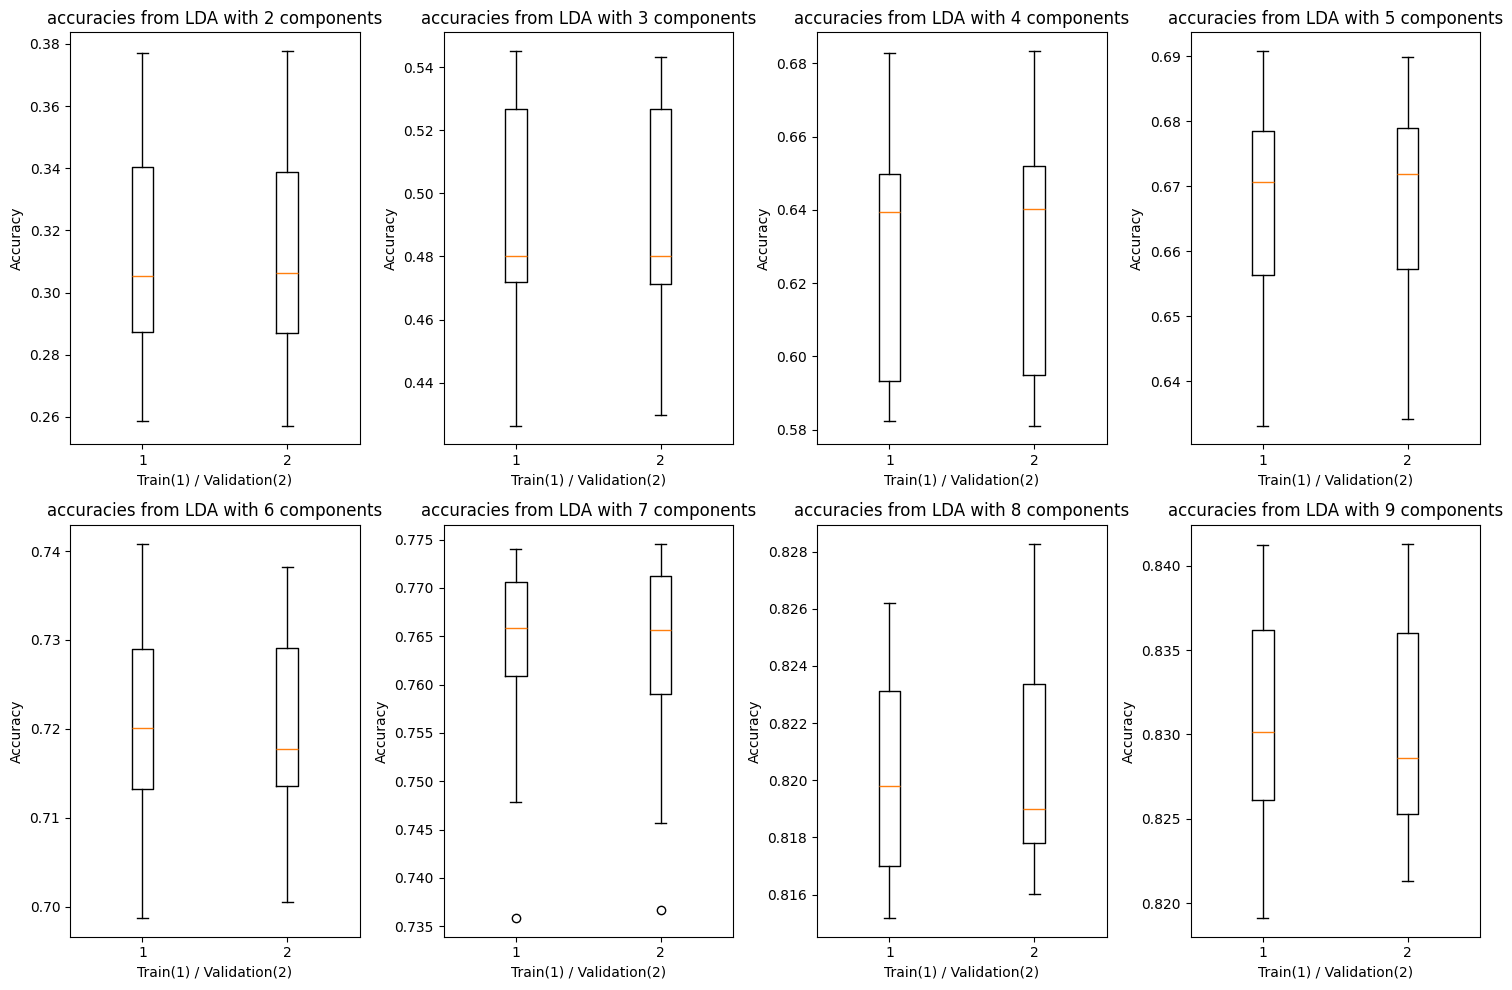

In [7]:
draw_plots('LDA')

## PCA

یکی از روش‌هایی که برای تنظیمات بهتر من استفاده کردم استفاده از روش‌های دیگر برای کاهش ابعاد بود در این بخش من تابع اولیه را کمی تغییر دادم که بتواند هم از پی‌سی‌ای هم از ال‌دی‌ای پشتیبانی کند و تنها 
با یک پارامتر بتوان بین آن‌ها جا‌به‌جا شد و در ادامه می‌بینیم نتایج ما به چه صورت تغییر می‌کند

از مزایای پی‌سی‌ای نسبت به ال‌دی‌ای در اینجا می‌توان به عدم محدودیت تعداد کامپوننت‌ها همانند ال‌دی‌ای را اشاره کرد و به نظر می‌رسد در تعداد بالا‌تر بتواند نتایج خوبی را به ما بدهد ولی خب با توجه به اینکه تعداد کامپوننت‌ها دارد زیاد می‌شود حجم محاسبات بیشتر شده و زمان اجرای کد به شدت بالا رفت پس در نتیجه تصمیم گرفتم برای حفظ سلامت سیستم خودم هم شده این روش را ادامه ندهم 

:))

ولی خب با توجه به اینکه تابع را کاملا برای استفاده از پی سی ای نیز اصلاح کردم میتوانید خودتان بیشترش را تست کنید

پ.ن این متنو در آخرین تیکه کار اضافه کردم جلوتر من در یک نقطه تصمیم گرفتم داده‌ها رو نرمالایز کنم و بعد از اون نتایج پی‌سی‌ای بهبود چشم‌گیری داشت ولی خب من بقیه کارهارو کرده‌بودم و خیلی امکان تغییر نداشتم

for 2 train mean accuracy is: 0.20658660714285712 and test mean accuracy is: 0.20619642857142856
for 5 train mean accuracy is: 0.48651517857142856 and test mean accuracy is: 0.48704107142857145
for 10 train mean accuracy is: 0.6664276785714286 and test mean accuracy is: 0.6645428571428571
for 15 train mean accuracy is: 0.72718125 and test mean accuracy is: 0.7266571428571429
for 20 train mean accuracy is: 0.7780017857142857 and test mean accuracy is: 0.7771964285714286
for 30 train mean accuracy is: 0.8138053571428572 and test mean accuracy is: 0.8120803571428571


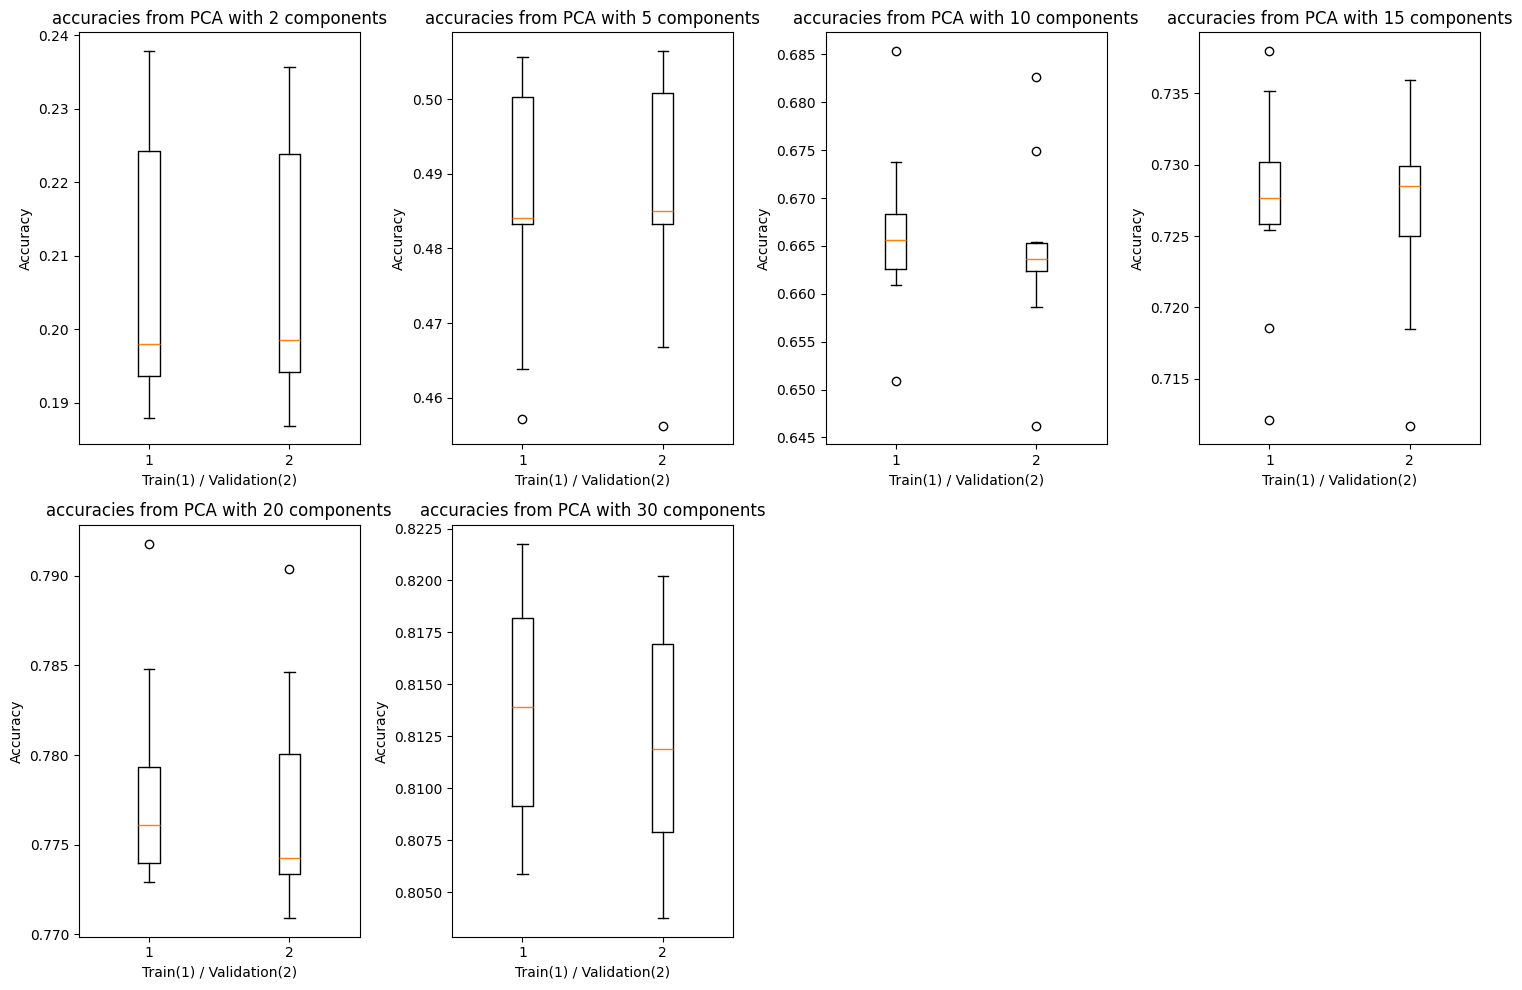

In [8]:
train_accuracy_data={2: [], 5: [], 10: [], 15: [], 20: [], 30: []}
val_accuracy_data={2: [], 5: [], 10: [], 15: [], 20: [], 30: []}
accuracy_calculator('PCA')

draw_plots('PCA')


## regularization

چیز دیگری که من امتحان کردم استفاده از رگولاریزیشن بود که این را به فانکشن اصلی اضافه کردم و نتایجش را در این بخش بررسی کردم و برای ۳ ضریب مختلف رگولاریزیشن ۰.۱ و ۰.۰۱ و ۰.۰۰۱ و ۰.۰۰۰۱ نتایج را بررسی کردم

for 2 train mean accuracy is: 0.34361294642857143 and test mean accuracy is: 0.34381249999999997
for 3 train mean accuracy is: 0.47364375000000003 and test mean accuracy is: 0.47255535714285707
for 4 train mean accuracy is: 0.6147540178571428 and test mean accuracy is: 0.6140535714285715
for 5 train mean accuracy is: 0.6446406249999999 and test mean accuracy is: 0.6447410714285715
for 6 train mean accuracy is: 0.7084401785714285 and test mean accuracy is: 0.7073214285714287
for 7 train mean accuracy is: 0.7633495535714285 and test mean accuracy is: 0.7625142857142857
for 8 train mean accuracy is: 0.8113397321428572 and test mean accuracy is: 0.8111571428571429
for 9 train mean accuracy is: 0.8209410714285715 and test mean accuracy is: 0.8205857142857143


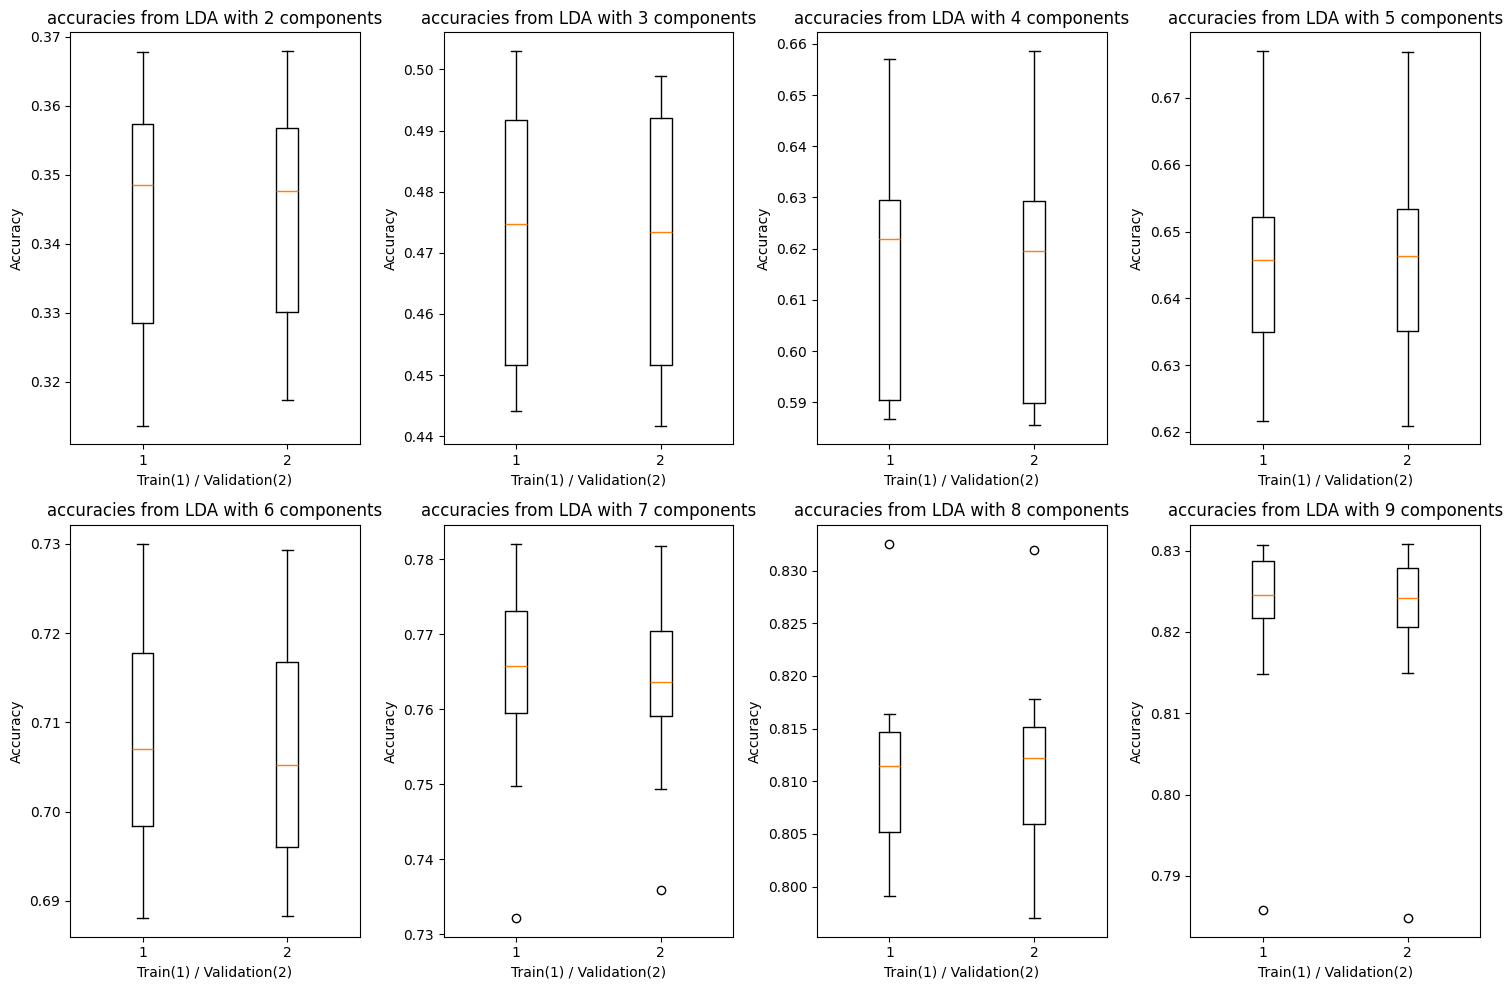

In [9]:
train_accuracy_data={2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
val_accuracy_data={2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
accuracy_calculator('LDA', 'logistic', 0.001)
draw_plots('LDA')

for 2 train mean accuracy is: 0.35049821428571437 and test mean accuracy is: 0.35086607142857146
for 3 train mean accuracy is: 0.49143526785714287 and test mean accuracy is: 0.49082142857142863
for 4 train mean accuracy is: 0.6116383928571428 and test mean accuracy is: 0.6121982142857143
for 5 train mean accuracy is: 0.6618491071428572 and test mean accuracy is: 0.6610589285714286
for 6 train mean accuracy is: 0.7199245535714286 and test mean accuracy is: 0.7208553571428571
for 7 train mean accuracy is: 0.7692174107142857 and test mean accuracy is: 0.7686053571428572
for 8 train mean accuracy is: 0.8166459821428571 and test mean accuracy is: 0.8157857142857143
for 9 train mean accuracy is: 0.8266312499999999 and test mean accuracy is: 0.8265017857142857


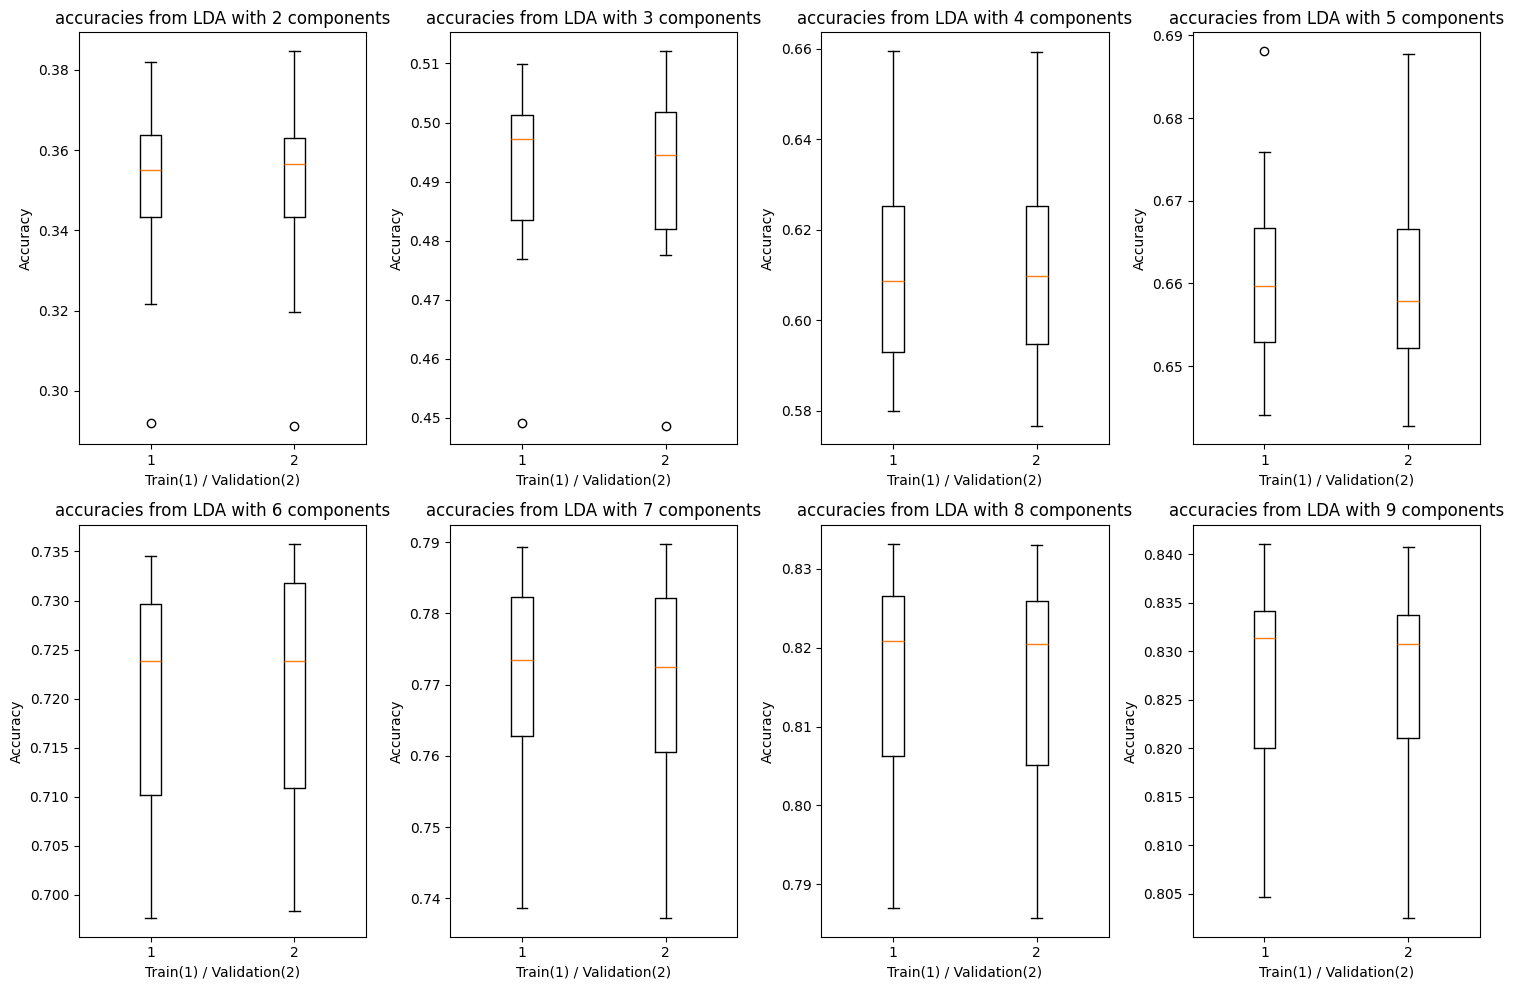

In [10]:
train_accuracy_data={2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
val_accuracy_data={2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
accuracy_calculator('LDA', 'logistic', 0.0001)
draw_plots('LDA')

for 2 train mean accuracy is: 0.34426741071428574 and test mean accuracy is: 0.34441785714285716
for 3 train mean accuracy is: 0.4769754464285715 and test mean accuracy is: 0.47765
for 4 train mean accuracy is: 0.620321875 and test mean accuracy is: 0.6198464285714286
for 5 train mean accuracy is: 0.661875 and test mean accuracy is: 0.660919642857143
for 6 train mean accuracy is: 0.7244196428571429 and test mean accuracy is: 0.724375
for 7 train mean accuracy is: 0.7560540178571429 and test mean accuracy is: 0.755682142857143
for 8 train mean accuracy is: 0.8138383928571429 and test mean accuracy is: 0.8143482142857144
for 9 train mean accuracy is: 0.8302308035714286 and test mean accuracy is: 0.8297714285714285


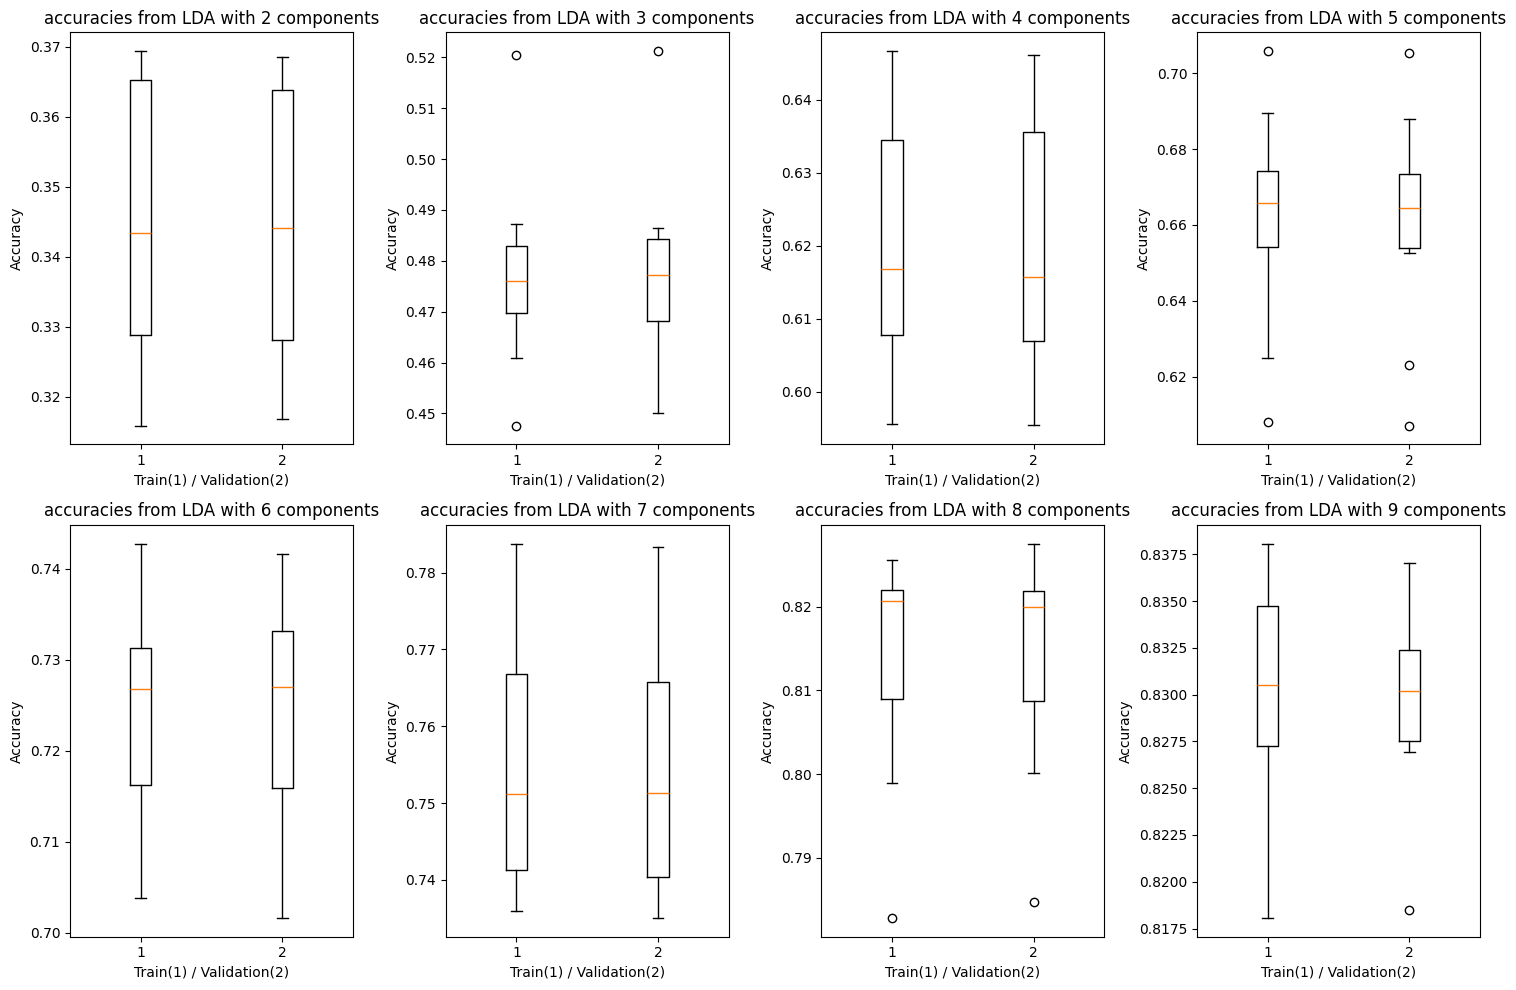

In [11]:
train_accuracy_data={2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
val_accuracy_data={2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
accuracy_calculator('LDA', 'logistic', 0.00001)
draw_plots('LDA')

## polynomial feature

در ادامه نرمالایز کردن را اضافه کردم و نتایج تغییر چشم گیری نداشت پس تصمیم گرفتم از پولینومیال فیچرها استفاده کنم و درجه ۲ را به آن اضافه کنم

for 2 train mean accuracy is: 0.4505191964285714 and test mean accuracy is: 0.4508875
for 3 train mean accuracy is: 0.6790598214285714 and test mean accuracy is: 0.6779285714285714
for 4 train mean accuracy is: 0.7757375 and test mean accuracy is: 0.7754392857142857
for 5 train mean accuracy is: 0.7998473214285715 and test mean accuracy is: 0.7993410714285715
for 6 train mean accuracy is: 0.8233308035714286 and test mean accuracy is: 0.8222446428571428
for 7 train mean accuracy is: 0.8515986607142857 and test mean accuracy is: 0.8501803571428571
for 8 train mean accuracy is: 0.8760339285714286 and test mean accuracy is: 0.8745767857142857
for 9 train mean accuracy is: 0.8828924107142857 and test mean accuracy is: 0.8815232142857143


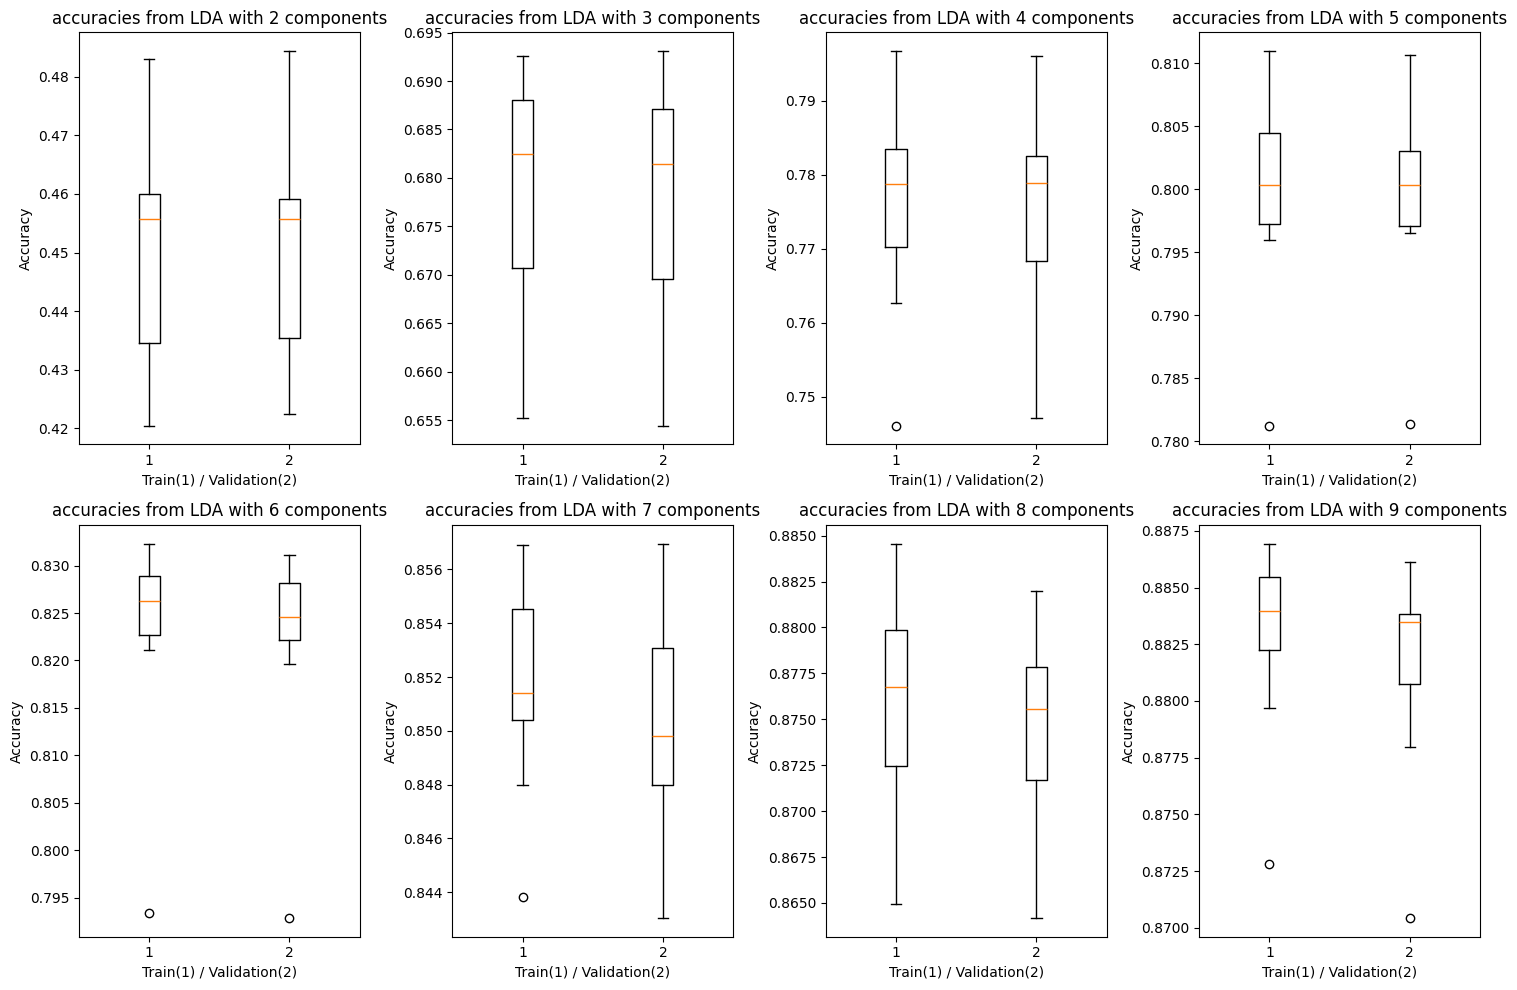

In [12]:
train_accuracy_data={2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
val_accuracy_data={2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
accuracy_calculator('LDA', 'logistic', 0.0001, True)
draw_plots('LDA')

## question 2 part 3

حال بهترین مدل را که در مرحله آخر قبلی دیدیم را روی داده تست خود اجرا میکنیم و ماتریکس مورد نظر را رسم میکنیم

our final accuracy is: 0.8776428571428572


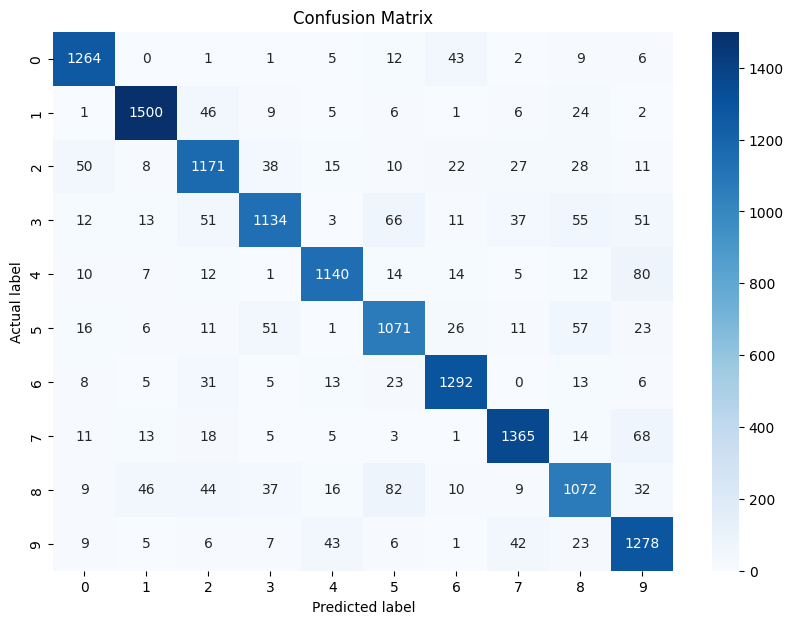

In [13]:
iterations= 10
n_components= 9
x_train_calculated, x_test_calculated= LDA_calculator(n_components, x_train_scaled, y_train)
poly = PolynomialFeatures(degree=2)
x_train_polynomial = poly.fit_transform(x_train_calculated)
x_test_polynomial = poly.transform(x_test_calculated)
x_train_calculated_df = pd.DataFrame(x_train_polynomial)
models= []
last_accuracy= 0

for i in range(iterations):
    for train_index, test_index in kFold_handler.split(x_train_calculated_df, y_train): 
        X_train_kFold, X_test_kFold = x_train_calculated_df.iloc[train_index], x_train_calculated_df.iloc[test_index] 
        y_train_kFold, y_test_kFold = y_train.iloc[train_index], y_train.iloc[test_index]
        model = Perceptron(penalty='l1', alpha=0.0001)
        model.fit(x_train_polynomial, y_train)
        y_train_pred = model.predict(x_train_polynomial)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        if(len(models)==0):
            models.append(model)
            last_accuracy= train_accuracy
        else:
            if(last_accuracy<train_accuracy):
                last_accuracy= train_accuracy
                models[0]= model
final_predictions = models[0].predict(x_test_polynomial)
final_accuracy = accuracy_score(y_test, final_predictions)
print(f"our final accuracy is: {final_accuracy}")
cm = confusion_matrix(y_test, final_predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()
